In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sys.path.append('../')

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/team_20_2023-01-10.csv')

In [3]:
# Create a dictionary to hold the counts
counts = {}

# Loop over the rows in the DataFrame
for _, row in df.iterrows():
    # Get the GazeDetections
    detections = row["GazeDetections"]
    # Skip rows with empty GazeDetections
    if detections == "[]":
        continue
    # Get the ClassID
    class_id = row["ClassID"]
    # If the ClassID is not in the counts dictionary, add it
    if class_id not in counts:
        counts[class_id] = {}
    # Loop over the other ClassIDs in the GazeDetections
    for other_id in eval(detections):
        # If the other ClassID is not in the counts dictionary, add it
        if other_id not in counts:
            counts[other_id] = {}
        # If the ClassID is not already in the other ClassID's counts, add it
        if class_id not in counts[other_id]:
            counts[other_id][class_id] = 0
        # Increment the count
        counts[other_id][class_id] += 1

# Create a list of the ClassIDs in the same order as the rows of the matrix
class_ids = sorted(list(counts.keys()))

# Create an empty matrix
matrix = [[0 for _ in range(len(class_ids))] for _ in range(len(class_ids))]

# Fill in the matrix
for i, class_id1 in enumerate(class_ids):
    for j, class_id2 in enumerate(class_ids):
        if class_id1 in counts and class_id2 in counts[class_id1]:
            matrix[j][i] = counts[class_id1][class_id2]

matrix_np = np.array(matrix)

In [4]:
def plot_matrix(matrix: np.ndarray, title: str) -> None:
    # Plot the matrix
    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.imshow(matrix, cmap="Blues")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_ids)))
    ax.set_yticks(np.arange(len(class_ids)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_ids)
    ax.set_yticklabels(class_ids)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_ids)):
        for j in range(len(class_ids)):
            ax.text(j, i, matrix[i][j], ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

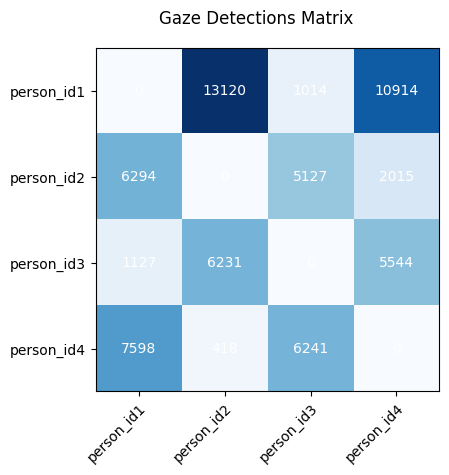

In [5]:
title = "Gaze Detections Matrix"
plot_matrix(matrix_np, title)

In [6]:
# compute the gaze asymmetriy/difference matrix
diff_np = abs(matrix_np - matrix_np.T)

# scale the difference matrix to the range 0 and 1
diff_scaled_np = (diff_np - np.min(diff_np)) / (np.max(diff_np) - np.min(diff_np))
diff_scaled_np = np.round(diff_scaled_np, decimals=2)

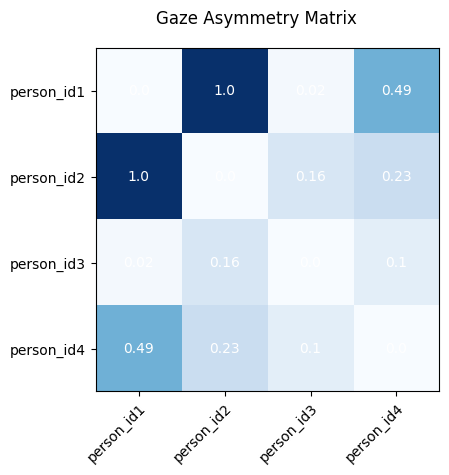

In [7]:
title = "Gaze Asymmetry Matrix"
plot_matrix(diff_scaled_np, title)

In [8]:
# Create a dictionary to store the mutual gaze detections
mutual_gaze_dict = {}

# Loop through each frame in the dataframe
for frame in df["Frame"].unique():

    # Get the rows corresponding to the current frame
    frame_rows = df[df["Frame"] == frame]

    # Get the ClassIDs and GazeDetections for the current frame
    class_ids = list(frame_rows["ClassID"])
    gaze_detections = [eval(detections) for detections in frame_rows["GazeDetections"]]

    # Loop through each pair of ClassIDs in the current frame
    for i, class_id_x in enumerate(class_ids):
        for class_id_y in gaze_detections[i]:
            if (class_id_y in class_ids) and (class_id_x in gaze_detections[class_ids.index(class_id_y)]):
                mutual_gaze_key = (class_id_x, class_id_y)
                mutual_gaze_dict[mutual_gaze_key] = mutual_gaze_dict.get(mutual_gaze_key, 0) + 1

# Create a pivot table of mutual gazes
mutual_gaze_matrix = pd.DataFrame(mutual_gaze_dict.values(),
                                   index=pd.MultiIndex.from_tuples(mutual_gaze_dict.keys()),
                                   columns=["Count"]).unstack(fill_value=0)

# Convert the matrix to an integer dtype
mutual_gaze_matrix = mutual_gaze_matrix.astype(int).to_numpy()


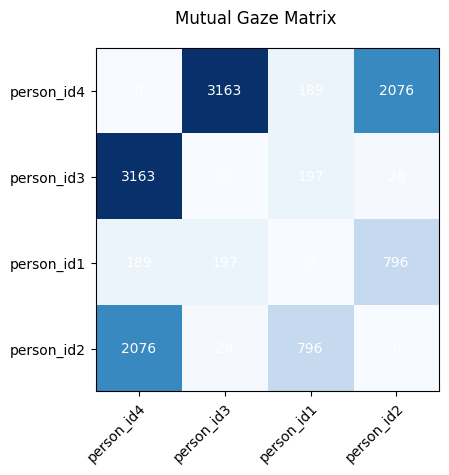

In [9]:
# Print the mutual_gaze_matrix
title="Mutual Gaze Matrix"
plot_matrix(mutual_gaze_matrix, title)

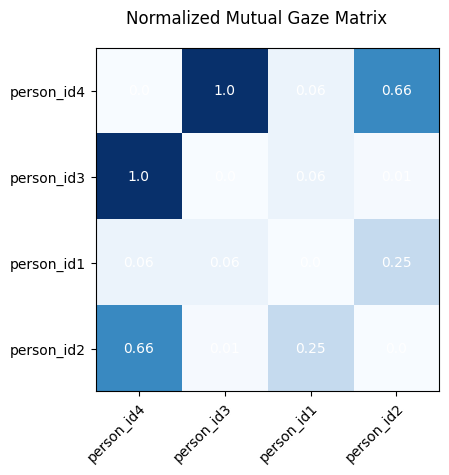

In [11]:
# min-max scaling
min_val = np.min(mutual_gaze_matrix)
max_val = np.max(mutual_gaze_matrix)
mutual_gaze_matrix_scaled = (mutual_gaze_matrix - min_val) / (max_val - min_val)
mutual_gaze_matrix_scaled = np.round(mutual_gaze_matrix_scaled, decimals=2)

title="Normalized Mutual Gaze Matrix"
plot_matrix(mutual_gaze_matrix_scaled, title)